# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

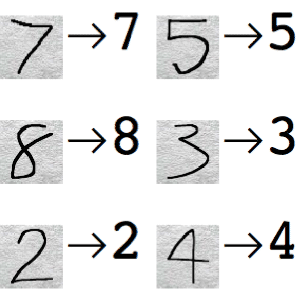

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

11490434/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


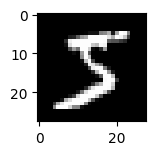

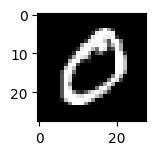

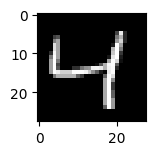

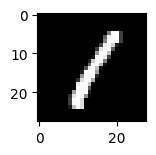

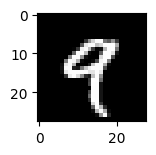

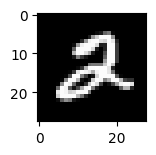

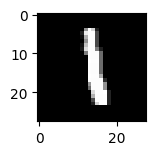

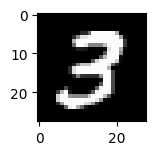

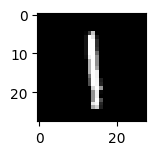

In [ ]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model
import os
import cv2

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [ ]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [ ]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [ ]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [ ]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [ ]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [ ]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.567
> 98.675
> 98.717
> 98.858
> 98.750


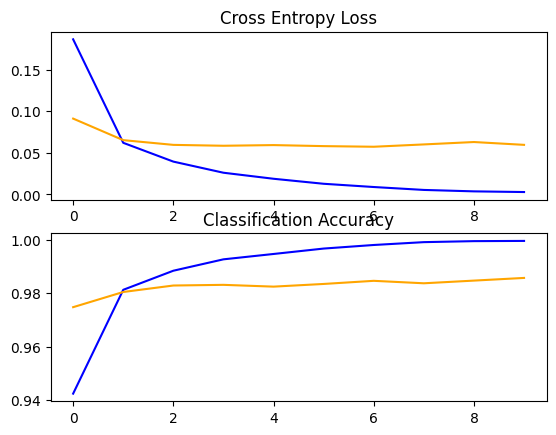

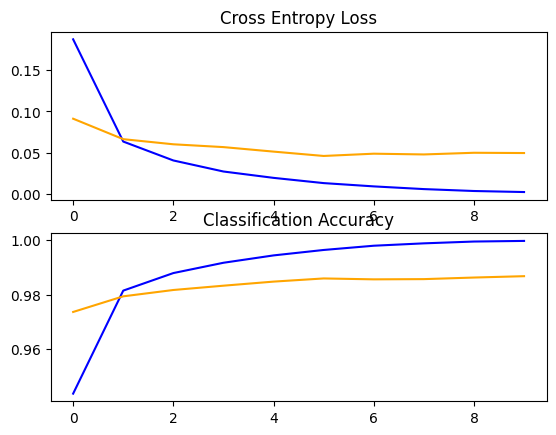

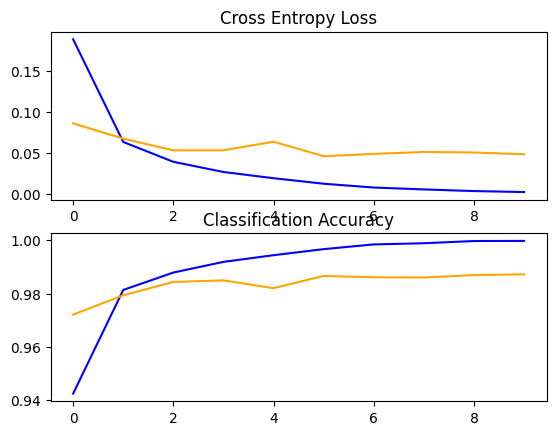

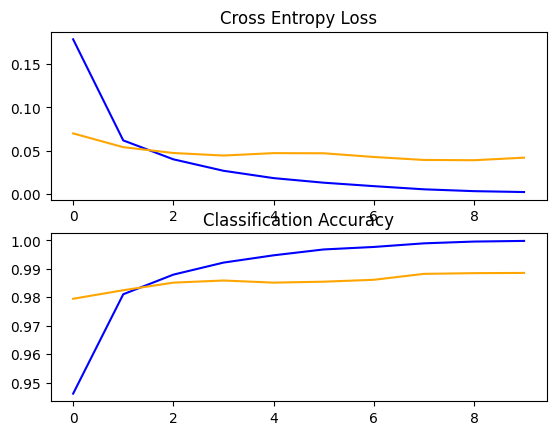

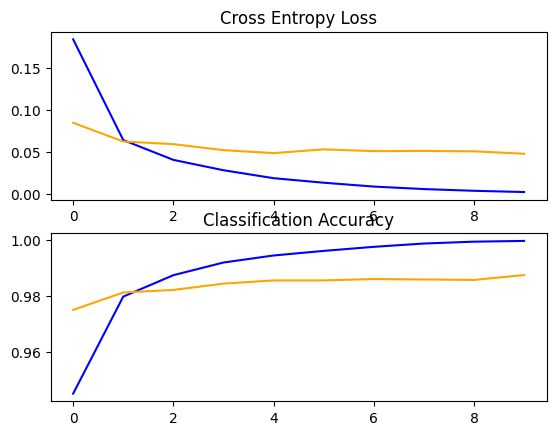

Accuracy: mean=98.713 std=0.095, n=5


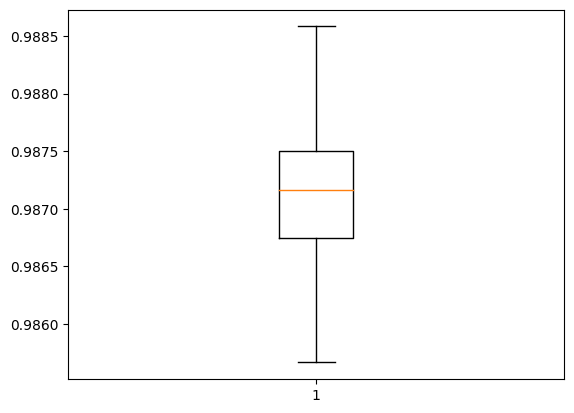

In [ ]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [ ]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

run_test_harness2()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/cs114.o21.x.lab01-competition"
model = load_model("final_model.h5")

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

def load_data(data_dir):
  img_data = []
  img_names = []
  for _, _, list_img_name in os.walk(data_dir):
    for img_name in list_img_name:
      img_path = os.path.join(data_dir, img_name) #Đường dẫn đầy đủ đến ảnh
      print(img_name) #In ra tên và định dạng của ảnh
      if img_name.lower().endswith(".heic") or "(" in img_name: #Bỏ qua những ảnh có định dạng .heic và những ảnh bị trùng tên
        continue
      else:
        img = load_img(img_path, grayscale=True, target_size=(28, 28)) #Đọc ảnh với kích cỡ 28x28 để phù hợp với mô hình
      img = np.array(img) #Chuyển ảnh thành mảng numpy
      img = cv2.GaussianBlur(img, (5, 5), 0) #Áp dụng làm mờ Gaussian lên ảnh
      _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY) #Sử dụng ngưỡng Otsu để chuyển đổi ảnh xám sang nhị phân
      thresholded_img = thresholded_img.reshape(1, 28, 28, 1)
      thresholded_img = thresholded_img.astype('float32')
      thresholded_img = thresholded_img / 255.0 #Chuẩn hóa giá trị pixel của ảnh
      thresholded_img = 1.0 - thresholded_img #Chuyển thành ảnh chữ trắng nền đen như dữ liệu huấn luyện
      img_names.append(img_name)
      img_data.append(thresholded_img)
  return img_names, img_data
img_names, img_data = load_data(data_dir)

ada82ca8d2873afb9cf1d2a73f43576d  -.png
aeae2ce93fcb7dbb3aacb94323c92cbf  -.jpg
af375b2b2aa5540644a67bb53d30a373  -.jpg
af29d11ce38959048e276d6dabae722c  -.PNG
ad0db8c8e152279af8dfe860d7e85789  -.jpg
ac391de7823bcaa065a13206d1b79386  -.jpg
af46432d3ec4b95fcefec47180af3372  -.png
abbde029f6c4be4c05bf727fb83f0f99  -.jpg
ad7854380e23e2100c423c3145293d86  -.png
abd3a2ba71770baf3e395dc1eb684e27  -.png
ace947c9a4fdbb5ef1139ee0ed5ebfca  -.png
ae8aeb0b8bb5332c877a9db346c47ffa  -.jpg
ad09a3fc5542df6f452b2943d94feb4a  -.jpg
aeff77b922be23f8149a37251d3430f1  -.jpg
ad893a18db37ef41b8dff4862562e5fc  -.png
ac7ffa543fc5e37a8e47517dafff6854  -.jpg
ac7fd0fc497269af1f0e541bc01e929d  -.jpg
ac2096fe847201ba549895486ae66553  -.jpg
ae8950807cc4f7a3a85bce75db3d21c1  -.png
acd8044500d45c6b866bd818ef220179  -.png
aef28774288f21fd4b8d74d03cdaf187  -.jpg
ae490ed464a1884da961bdcb7d2bc3de  -.jpg
ae1376879fe7360cc14e643040bcf170  -.jpg
af6f93e748ffdff7045156682e2c901f  -.jpg
aedea2ecf79f7eb2dbf738fc38be84e4  -.jpg


In [ ]:
print(len(img_names))
print(len(img_data))

2898
2898


In [ ]:
predicts = []
for i in range (0, len(img_data)):
  predict = argmax(model.predict(img_data[i]))
  predicts.append(predict)


1/1 [==============================] - 0s 21ms/step


In [ ]:
for i in range (0, len(img_data)):
  print(f'{img_names[i]},{predicts[i]}')

ada82ca8d2873afb9cf1d2a73f43576d  -.png,8
aeae2ce93fcb7dbb3aacb94323c92cbf  -.jpg,3
af375b2b2aa5540644a67bb53d30a373  -.jpg,5
af29d11ce38959048e276d6dabae722c  -.PNG,5
ad0db8c8e152279af8dfe860d7e85789  -.jpg,3
ac391de7823bcaa065a13206d1b79386  -.jpg,3
af46432d3ec4b95fcefec47180af3372  -.png,8
abbde029f6c4be4c05bf727fb83f0f99  -.jpg,7
ad7854380e23e2100c423c3145293d86  -.png,3
abd3a2ba71770baf3e395dc1eb684e27  -.png,5
ace947c9a4fdbb5ef1139ee0ed5ebfca  -.png,0
ae8aeb0b8bb5332c877a9db346c47ffa  -.jpg,7
ad09a3fc5542df6f452b2943d94feb4a  -.jpg,3
aeff77b922be23f8149a37251d3430f1  -.jpg,3
ad893a18db37ef41b8dff4862562e5fc  -.png,4
ac7ffa543fc5e37a8e47517dafff6854  -.jpg,3
ac7fd0fc497269af1f0e541bc01e929d  -.jpg,3
ac2096fe847201ba549895486ae66553  -.jpg,8
ae8950807cc4f7a3a85bce75db3d21c1  -.png,5
acd8044500d45c6b866bd818ef220179  -.png,1
aef28774288f21fd4b8d74d03cdaf187  -.jpg,4
ae490ed464a1884da961bdcb7d2bc3de  -.jpg,9
ae1376879fe7360cc14e643040bcf170  -.jpg,2
af6f93e748ffdff7045156682e2c901f  

In [ ]:
import shutil
destination_root = "/content/drive/MyDrive/PhanLoai"
for img_name, label in zip(img_names, predicts):
  # Đường dẫn đầy đủ của ảnh gốc
  img_path = os.path.join(data_dir, img_name)

  # Đường dẫn đích đến
  destination_path = os.path.join(destination_root, str(label), img_name)

  # Sao chép ảnh đến thư mục đích
  shutil.copy(img_path, destination_path)

In [ ]:
import os
# Lấy thông tin của từng ảnh sau khi đã gán nhãn bằng model và gán nhãn thủ công
data_dir = "/content/drive/MyDrive/PhanLoai"
count = -1
for _, a, list_img_name in os.walk(data_dir):
  for img_name in list_img_name:
    print(img_name+f",{count}" )
  count += 1

af46432d3ec4b95fcefec47180af3372  -.png,0
b26ac6eec5a7b4b496e25e4f77cdd976  -.jpg,0
b3561052e2c66f6e95f6ef1bf3342f19  -.jpg,0
b3706af383f68058360364213f9c3c90  -.jpg,0
b07ec977b63b77c3180d5a1b9e3435e4  -.jpg,0
b22f6af1004237e327e0171be16c1d8c  -.jpg,0
b368df350afb37456499ef3da952abfe  -.png,0
b0730684101198efd4831036a378a169  -.png,0
b620bbd3b397729503b2a7e77d26a145  -.png,0
b56e7669651abef29906242370698e03  -.jpg,0
b599da0dd719f8cd93ace8308403b023  -.png,0
b68dbb8773289e718a9b5e5c4629330f  -.jpg,0
b8d39984c65a4d8cf345ab9b2a67b656  -.jpg,0
b8550b983e2ba7fbdaade18f48d782ae  -.jpg,0
b7de165a25e6efbd4e68bc7f70592211  -.png,0
b7da2f978c5ad6f7578660ebcbd52a0c  -.jpg,0
b96dcef90ba1627f6ee7cefedc36526f  -.jpg,0
b9d337a42cca7b599de1b704a0fdd480  -.png,0
bf5721699a1f504e498545066da66863  -.jpg,0
bf74776f137229f2555197dfdf74fa9c  -.jpg,0
bf6ca5e052d9f940a4dfde0abac01830  -.jpg,0
bdb6c970db332f4eb3364dc46a3e83b1  -.jpg,0
bce01b542a1a5b43256bd82540ceecf6  -.png,0
be2be88237107af4869c087954b2ce1d  